In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Load_Data
import os
import time
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import keras.callbacks
%matplotlib inline

C:\Users\windo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [12]:
train_data = Load_Data.load_train_data()          #returns a dictionary with xtrain and ytrain as keys
test_data = Load_Data.load_test_data()            #returns a dictionary with xtest and ytest as keys
labels = Load_Data.get_labels()

In [13]:
print(train_data.keys())
print(test_data.keys())

dict_keys(['xtrain', 'ytrain'])
dict_keys(['xtest', 'ytest'])


In [14]:
print(labels)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# Helper function to plot images

In [15]:
def plot_images(images, true_classes, pred_classes=None, incorrect_pred=False):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace = 0.3)
    
    idx = np.random.choice(np.arange(len(images)), 16, replace=False)
    random_images = images[idx]
    random_true_classes = true_classes[idx]
    
    if incorrect_pred:
        random_pred_classes = pred_classes[idx]
        
    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], interpolation='spline16')
        ax.set_xticks([])
        ax.set_yticks([])
        
        msg = 'True : {}'.format(labels[random_true_classes[i]].decode('utf-8'))
        
        if incorrect_pred:
            msg = msg + '\nPred : {}'.format(labels[random_pred_classes[i]].decode('utf-8'))
        ax.set_xlabel(msg)

# Visualization of Data

No of Train Images: 50000
No of Test Images: 10000
Shape of an image: 32 32 3
No of classes: 10
-----------------------------------------------------------
Example Images: 


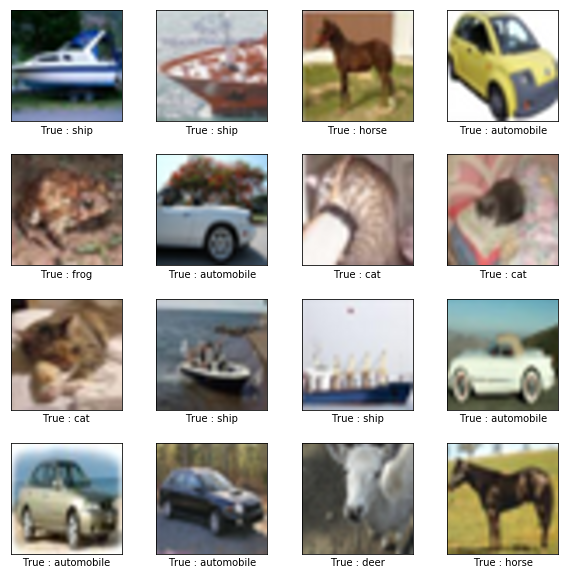

In [16]:
length, breadth, depth = train_data['xtrain'].shape[1:]
no_of_train_images = train_data['xtrain'].shape[0]
no_of_test_images = test_data['xtest'].shape[0]
no_of_classes = len(labels)
print("No of Train Images: {}".format(no_of_train_images))
print("No of Test Images: {}".format(no_of_test_images))
print("Shape of an image: {} {} {}".format(length, breadth, depth))
print("No of classes: {}".format(no_of_classes))
print("-----------------------------------------------------------")
print("Example Images: ")
plot_images(train_data['xtrain'], train_data['ytrain'], labels)

In [17]:
save_dir = 'saved_model/'
save_path = os.path.join(save_dir, 'cifar10_cnn_')

# Helper function to Create Network

In [18]:
def create_network(xtrain, show_summary):
    print("Creating CNN Network")
    start = time.time()
    model = Sequential()

    conv1 = model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape = (length, breadth, depth),\
                             padding='same' ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    conv2 = model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same' ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    conv3 = model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same' ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    conv4 = model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same' ,activation='relu'))
    #     max4 = model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    # conv5 = model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same' ,activation='relu'))
    # max5 = model.add(MaxPooling2D(pool_size=(2, 2)))
    # conv6 = model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same' ,activation='relu'))
    #     max6 = model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    dense1 = model.add(Dense(units=2304, activation='relu'))
    model.add(Dropout(0.25))
    dense2 = model.add(Dense(units=1024, activation='relu'))
    
    model.add(Reshape((32, 32, 1)))
    conv5 = model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same' ,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    conv6 = model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same' ,activation='relu'))

    model.add(Flatten())
    dense3 = model.add(Dense(units=512, activation='relu'))
    dense4 = model.add(Dense(units=128, activation='relu'))
    dense5 = model.add(Dense(units=no_of_classes, activation='softmax'))
    
    print("Model Created in {} sec\n".format(time.time()-start))
    if show_summary:
        print("Model Summary")
        model.summary()
    return model

# Helper function to get one-hot-encoded-labels

In [19]:
def get_categorical(ytrain, ytest):
    return (keras.utils.to_categorical(ytrain, num_classes=no_of_classes),\
            keras.utils.to_categorical(ytest, num_classes=no_of_classes))

# Helper function to Train Network

In [20]:
def train_network(train_data, test_data, epochs, verbose, show_summary, initial_epoch=0, model=None):
    
    if initial_epoch==0:
        model = create_network(train_data['xtrain'], show_summary=show_summary)
        print("\n--------------------------------------------")
        print("\nTraining the Network")
        start=time.time()
        opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        
    else:
        print("\nTraining the Network for more epochs")
        start=time.time()
        model=model
    
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.005, patience=25,\
                                                                verbose=1, mode='auto')
    ytrain, ytest = get_categorical(train_data['ytrain'], test_data['ytest'])
    model.fit(train_data['xtrain'], ytrain, epochs=epochs, initial_epoch=initial_epoch, verbose=verbose,\
              batch_size=128, callbacks=[early_stopping_callback], validation_data=(test_data['xtest'], ytest), shuffle=True)
    
    print("Model trained in {} sec\n".format(time.time()-start))
    return model

# Helper function to check if model already exists

In [21]:
def is_model_saved():
    print("Trying to restore saved model")
    return os.path.exists(save_path+str(len(os.listdir(save_dir)))+'.h5')

In [22]:
def cnn_model(train_data, test_data, epochs, initial_epoch=0, verbose=1, show_summary=True, show_accuracy=False):
    model_saved=is_model_saved()
    if initial_epoch != 0 and model_saved:
        print("Previous Model Restored")
        model = load_model(save_path+str(len(os.listdir(save_dir)))+'.h5')
        print("Loss and Accuracy till now")
        loss_and_accuracy(model, test_data)
        print("--------------------------------------------\n")
        model = train_network(train_data, test_data, epochs, verbose, show_summary, initial_epoch, model)   
    
    elif model_saved:
        print("Model Restored\n\n")
        model = load_model(save_path+str(len(os.listdir(save_dir)))+'.h5')
        if show_summary:
            print("Model Summary")
            model.summary()
            
    else:
        print("Unable to restore model\n\n")
        print("--------------------------------------------\n")
        print("Creating and training new CNN Model\n")
        model = train_network(train_data, test_data, epochs, verbose, show_summary, initial_epoch)
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    print("\n\n--------------------------------------------\n")
    print("Saving trained Model")
    model.save(save_path+str(len(os.listdir(save_dir))+1)+'.h5') 
    print("Model Saved")
    
    if show_accuracy:
        print("\n\n--------------------------------------------\n")
        loss_and_accuracy(model, test_data)
    
    return model

# Helper function to train model for more epochs

In [23]:
def train_for_more_epochs(train_data, test_data, epochs, initial_epoch):
    return cnn_model(train_data, test_data, epochs+initial_epoch, initial_epoch)

# Helper function to calculate loss and accuracy

In [24]:
def loss_and_accuracy(model, test_data):
    loss, acc = model.evaluate(test_data['xtest'], keras.utils.to_categorical(test_data['ytest'],10), batch_size=128)
    print("\n\nLoss     : {}\nAccuracy : {}\n".format(loss,acc))

# Helper function to predict classes

In [25]:
def predict_classes(model, xtest):
    pred_classes = model.predict_classes(xtest, verbose=0)
    return pred_classes

# Helper function to plot incorrect predictions

In [26]:
def plot_incorrect_pred(correct, pred_classes):
    incorrect = (correct == False)
    
    images_incorrect = test_data['xtest'][incorrect]
    true_classes_incorrect = test_data['ytest'][incorrect]
    pred_classes_incorrect = pred_classes[incorrect]
    print("--------------------------------------------")
    print("Incorrect Prediction Examples")
    plot_images(images_incorrect, true_classes_incorrect, pred_classes_incorrect, incorrect_pred=True)

# Helper function to plot confusion matrix

In [27]:
def plot_confusion_matrix(pred_classes):
    print("--------------------------------------------\n")
    print("Confusion Matrix")
    conf_matrix = confusion_matrix(y_true=test_data['ytest'], y_pred=pred_classes)
    for i in range(len(labels)):
        class_name  = "({}) : {}".format(i, labels[i].decode('utf-8'))
        print(conf_matrix[i], class_name)
    
    class_numbers = [" ({0})".format(i) for i in range(len(labels))]
    print("".join(class_numbers))

# Helper function to calculate accuracy on test images

In [28]:
def classification_accuracy(correct):
    mean = correct.mean()
    total_correct = correct.sum()
    return mean,total_correct

def test_accuracy(model, test_data, show_confusion_matrix = False, show_example_errors = False):
    pred_classes = predict_classes(model, test_data['xtest'])
    
    correct = (pred_classes == test_data['ytest'])   
    accuracy, total_correct = classification_accuracy(correct)
    
    print("\nClassification Accuracy on Test Set : {0:.1%}".format(accuracy))
    print("Total Images : {}".format(len(pred_classes)))
    print("Correct Predictions : {}".format(total_correct))
    print("Incorrect Predictions : {}\n".format(len(pred_classes)-total_correct))
    
    if show_confusion_matrix:
        plot_confusion_matrix(pred_classes=pred_classes)
    
    if show_example_errors:
        plot_incorrect_pred(correct, pred_classes)

In [29]:
model = load_model(save_path+str(len(os.listdir(save_dir)))+'.h5')
# epochs = 50
# model=cnn_model(train_data, test_data, epochs=epochs)

In [19]:
loss_and_accuracy(model, test_data)

 9984/10000 [============================>.] - ETA: 0s

Loss     : 1.3444771360397338
Accuracy : 0.766



In [20]:
#run this code to train for more epochs

# more_epochs=50
# initial_epoch=epochs
# model = train_for_more_epochs(train_data, test_data, epochs=more_epochs, initial_epoch=initial_epoch)


Classification Accuracy on Test Set : 76.6%
Total Images : 10000
Correct Predictions : 7660
Incorrect Predictions : 2340

--------------------------------------------

Confusion Matrix
[806  16  22  14  14   3   6  13  68  38] (0) : airplane
[ 16 876   0   3   0   2   5   1  31  66] (1) : automobile
[ 66   7 611  70 107  39  31  39  22   8] (2) : bird
[ 18  17  45 548  86 133  39  56  35  23] (3) : cat
[ 19   6  32  36 800  25  18  49  13   2] (4) : deer
[ 13   8  36 161  50 631  14  55  23   9] (5) : dog
[  5  14  35  49  57  22 798   7   8   5] (6) : frog
[ 15   5  17  32  46  34   3 824   6  18] (7) : horse
[ 33  22   4   8   2   3   1   2 908  17] (8) : ship
[ 16  57   4   8   5   1   4  11  36 858] (9) : truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
--------------------------------------------
Incorrect Prediction Examples


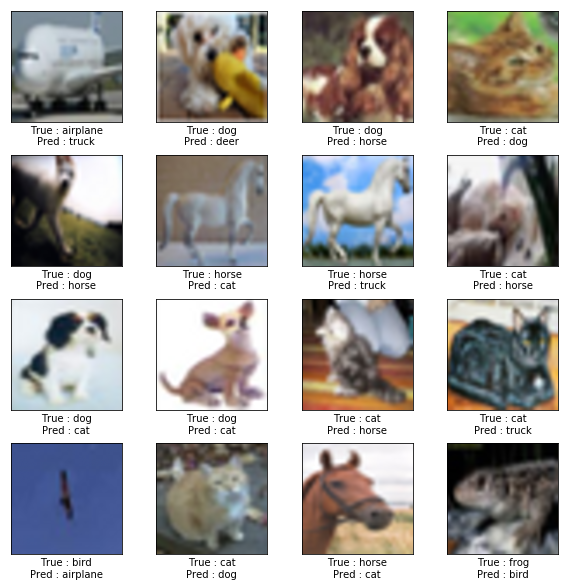

In [21]:
test_accuracy(model, test_data, show_confusion_matrix = True, show_example_errors = True)

In [5]:
import cv2

Original size of image : (100, 100, 3)


Text(0.5,0,'Predicted Label : dog')

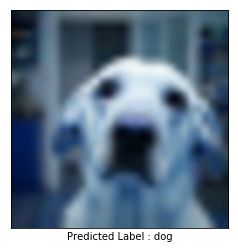

In [111]:
#Example 1

img = cv2.imread('dog_example.jpg')
print("Original size of image : {}".format(img.shape))

#resizing image to 32*32*3
img = cv2.pyrDown(img)
img = cv2.resize(img, (32, 32))

#Predicting the class
pred = predict_classes(model, img.reshape(1, 32, 32, 3))

msg = "Predicted Label : {}".format(labels[pred[0]].decode('utf-8'))
plt.imshow(img, interpolation='spline16')
plt.xticks([])
plt.yticks([])
plt.xlabel(msg)

Original size of image : (100, 100, 3)


Text(0.5,0,'Predicted Label : truck')

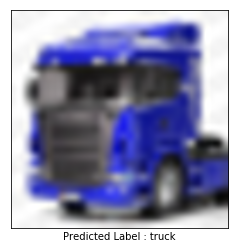

In [112]:
#Example 2

img = cv2.imread('truck_example.jpg')
print("Original size of image : {}".format(img.shape))

#resizing image to 32*32*3
img = cv2.pyrDown(img)
img = cv2.resize(img, (32, 32))

#Predicting the class
pred = predict_classes(model, img.reshape(1, 32, 32, 3))

msg = "Predicted Label : {}".format(labels[pred[0]].decode('utf-8'))
plt.imshow(img, interpolation='spline16')
plt.xticks([])
plt.yticks([])
plt.xlabel(msg)

Original size of image : (100, 100, 3)


Text(0.5,0,'Predicted Label : airplane')

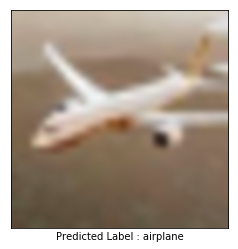

In [113]:
#Example 3

img = cv2.imread('airplane_example.jpg')
print("Original size of image : {}".format(img.shape))

#resizing image to 32*32*3
img = cv2.pyrDown(img)
img = cv2.resize(img, (32, 32))

#Predicting the class
pred = predict_classes(model, img.reshape(1, 32, 32, 3))

msg = "Predicted Label : {}".format(labels[pred[0]].decode('utf-8'))
plt.imshow(img, interpolation='spline16')
plt.xticks([])
plt.yticks([])
plt.xlabel(msg)

Original size of image : (100, 100, 3)


Text(0.5,0,'Predicted Label : automobile')

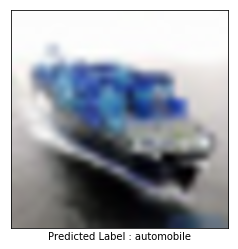

In [114]:
#Example 4

img = cv2.imread('ship_example.jpg')
print("Original size of image : {}".format(img.shape))

#resizing image to 32*32*3
img = cv2.pyrDown(img)
img = cv2.resize(img, (32, 32))

#Predicting the class
pred = predict_classes(model, img.reshape(1, 32, 32, 3))

msg = "Predicted Label : {}".format(labels[pred[0]].decode('utf-8'))
plt.imshow(img, interpolation='spline16')
plt.xticks([])
plt.yticks([])
plt.xlabel(msg)